In [1]:
import torch
import dataset as my_dataset
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [3]:
path = "/home/host/Documents/JupyterProjects/Test_ML_DBA/dataset_test_task/"

loaded_data = my_dataset.DataLoad(path)
loaded_data.data.head()

,image,label
0,30900_5_010.jpg,010
1,267155_9_010.jpg,010
2,125867_3_000.jpg,000
3,10762_10_010.jpg,010
4,68924_5_000.jpg,000


In [4]:
data = loaded_data.data
data.shape

(6000, 2)

In [5]:
# Дисбаланс классов!!!

# [000] = 2186
# [001] = 545
# [010] = 2008
# [011] = 5
# [100] = 1226
# [101] = 8
# [110] = 22
# [111] = 0 - нет данных

main_df = my_dataset.augmented_dataset(path, data)
print('Размер набора данных', main_df.shape)

Размер набора данных (15061, 2)


In [6]:
x_train, x_valid, x_test = my_dataset.split_data(main_df)

x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print('Размер тренировочного набора данных', x_train.shape)
print('Размер валидационного набора данных', x_valid.shape)
print('Размер тестового набора данных', x_test.shape)

Размер тренировочного набора данных (12048, 2)
Размер валидационного набора данных (1506, 2)
Размер тестового набора данных (1507, 2)


In [7]:
from dataset import CustomDataset

train_dataset = CustomDataset(data_frame=x_train)
valid_dataset = CustomDataset(data_frame=x_valid)
test_dataset = CustomDataset(data_frame=x_test)

In [8]:
from torch.utils.data import DataLoader

batch_size = 64 # размер батча
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))

189


In [9]:
import model
from train import train_model

net = model.CNN().to(device)

loss_history, best_model = train_model(train_loader, valid_loader, net, epochs=5, device=device)

tensor([4., 6., 3.,  ..., 5., 0., 6.])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0., 6., 3.,  ..., 5., 0., 6.])
Epoch [0/5], loss = 1.8729 acc_val = 0.4482
tensor([1., 6., 3.,  ..., 5., 1., 6.])
Epoch [1/5], loss = 1.6539 acc_val = 0.5551
tensor([1., 6., 3.,  ..., 5., 4., 6.])
Epoch [2/5], loss = 1.6043 acc_val = 0.5624
tensor([1., 6., 3.,  ..., 5., 4., 6.])
Epoch [3/5], loss = 1.5764 acc_val = 0.5704
tensor([0., 6., 3.,  ..., 5., 4., 6.])
Epoch [4/5], loss = 1.5581 acc_val = 0.5850


In [10]:
from train import test_model

y_pred_test = test_model(model=best_model, loader_test=test_loader, device=device)


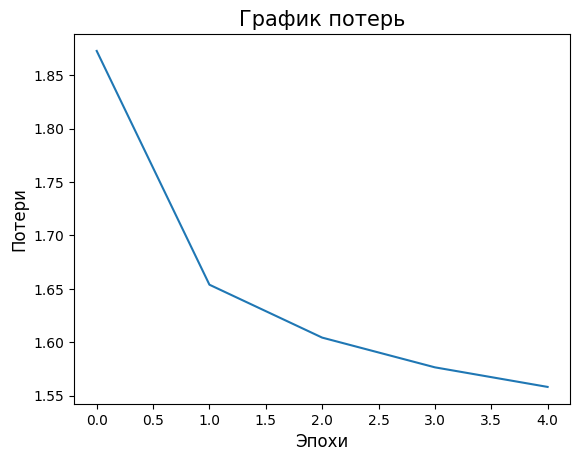

In [11]:
from matplotlib import pyplot as plt

plt.title('График потерь',fontsize=15)
plt.xlabel('Эпохи',fontsize=12)
plt.ylabel('Потери',fontsize=12)
plt.plot(loss_history)

plt.show()

In [12]:
import sklearn.metrics as metrics
import numpy as np

y_true_test = np.array(x_test['label'])

y_predict_test = []
for y_pred in y_pred_test:
    y_predict_test.append(y_pred)
Y_predict_test = np.array(y_predict_test).reshape(-1)

# [000] - 0
# [001] = 1
# [010] = 2
# [011] = 3
# [100] = 4
# [101] = 5
# [110] = 6
# [111] = нет данных
result_total = metrics.f1_score(y_true_test, Y_predict_test, average='micro')
class_results = metrics.f1_score(y_true_test, Y_predict_test, average=None)


print("Оценка качества F1 (общая):", result_total)
print()
print("Оценка качества F1 по классам:")
print("Оценка качества F1 (000):", class_results[0])
print("Оценка качества F1 (001):", class_results[1])
print("Оценка качества F1 (010):", class_results[2])
print("Оценка качества F1 (011):", class_results[3])
print("Оценка качества F1 (100):", class_results[4])
print("Оценка качества F1 (101):", class_results[5])
print("Оценка качества F1 (110):", class_results[6])

Оценка качества F1 (общая): 0.6078301260783012

Оценка качества F1 по классам:
Оценка качества F1 (000): 0.34541577825159914
Оценка качества F1 (001): 0.4315545243619489
Оценка качества F1 (010): 0.4439359267734554
Оценка качества F1 (011): 0.977886977886978
Оценка качества F1 (100): 0.32589285714285715
Оценка качества F1 (101): 0.9481481481481482
Оценка качества F1 (110): 0.8681055155875299


In [13]:
from sklearn.metrics import confusion_matrix

conf_matrix_test = confusion_matrix(y_true_test, Y_predict_test)
conf_matrix_labels_test = pd.DataFrame(conf_matrix_test, 
                                       columns = ['000', '001', '010', '011', '100', '101', '110'], 
                                       index = ['000', '001', '010', '011', '100', '101', '110'])
conf_matrix_labels_test

,000,001,010,011,100,101,110
000,81,29,55,1,47,4,2
001,50,93,34,1,34,4,2
010,39,24,97,2,33,1,5
011,0,1,0,199,0,0,0
100,60,59,44,4,73,3,3
101,2,1,0,0,4,192,2
110,18,6,6,0,11,0,181
